The purpose of this notebook is to walk you through some of the fundamental principles of optimization, orient you to `scipy.optimize`, and build familiarity with specifying and solving optimization problems in code.

# Background

Optimization is the study of finding input values to a function (called the *objective function* or *loss function*) that make the output as small (or large) as possible; we also use the terms *minimization* and *maximization*. In general, we will talk about minimization, because a maximization problem can be turned into a minimization problem by taking the negeative of the objective function. There is also the problem of *root finding*, which is to find values of $x$ such that $f(x)=0$.

Optimization underlies almost everything we will do in the second half of the course: the variables we optimize over specify some structure that we think is present in a certain data set, and the objective function quantifies how well or poorly those variables describe the data set.

There are several important discinctions in optimization problems that can be made in terms of properties of the objective function:
* Discrete vs. Continuous domain
    * In general, optimizing over a continuous domain is easier than a discrete one, because in the continuous case we can take advantage of calculus to find a direction in which to move that reduces the value of the objective function. For discrete domains, it can be necessary to check all possible input values, which can be very computationally intensive (cf. "combinatorial explosion")
* Constrained vs. Unconstrained
    * Often in optimization you will know ahead of time that the input to your objective function should obey certain constraints, e.g. it should be nonnegative. This introduces extra complexity to the problem because the interior and the boundary of the constraint set can typically not be treated in exactly the same way, and so need to be considered separately. In the case of a high-dimensional domain and a complex set of constraints, this can become computationally costly.
    * Constraints can be further categorized as *linear* vs *nonlinear*, and *equality* vs. *inequality*
        * A linear constraint specifies the value of a linear function of the optimization variable; a nonlinear constraint uses any nonlinear function
        * An equality constraint is of the form $g(x)=0$, while an inequality constraint is of the form $g(x)\le 0$. Equality constraints restict the domain of optimization to a set with strictly smaller dimension than the full domain of the objective function, while inequality constraints specify full-dimensional subsets of the domain. Linear inequality constraints correspond to *half-spaces*; take for example $\{(x,y)| x\le 0\}$
* Linear vs. Nonlinear
    * Linear functions are very easy to deal with, but don't have minima if the domain is unbounded (what's the minimum of $y=x$ over $x\in (-\infty, \infty)$?). For that reason, linear optimization problems are typically subject to constraints. Optimization of linear functions subject to linear inequality constraints is an entire field of study known as *linear programming*, and it can be solved using an algorithm called the *simplex algorithm*.
    * Nonlinear functions are too large a class to say anything completely general about; among nonlinear functions, the next important distinction to make is between *convex* and *non-convex* functions
* Convex vs. Non-convex
    * We say that a function $f$ is convex if for every pair of points $x, y$ and every scalar $\lambda \in[0,1]$, the following inequality holds: $f(\lambda x + (1-\lambda)y) \le \lambda f(x) +(1-\lambda) f(y)$. Geometrically, this means that if we draw a line connecting two points on the graph of $f(x)$, that line will always lie above the graph of the function.
    * An equivalent condition in the case that $f$ is smooth is that the second derivative of $f$ is always non-negative. Note that this statement has a preferred direction; this is why we restrict our attention to minimization problems.
    * The most important property of an optimization problem with a convex objective function is that *every local minimum is a global minimum*. This means that an algorithm that just always moves "downhill" will always find the minimum if one exists
    * Non-convex objective functions can have many local minima that are not global minima, so one of the main features that's needed to solve a nonconvex optimization problem is the ability to "break out" of local minima.
    * The vast majority of interesting problems are non-convex
* Regularized vs. Non-regularized
    * It is often the case that many different input values can have equal (or nearly equal) objective function values. Regularization is when you add an extra term to the objective function so that the minimum becomes unique.
    * The regularization term should be small compared to the objective function values.
    * Common choices of regularizer include the 2-norm $\Vert x \Vert$, the 1-norm $\Vert x \Vert_1 = \sum_i |x_i|$, or a linear combination of the two.
    * It's convenient if the regularizer is a convex function

Likewise, there are many methods that can be used for optimization depending on properties of the problem. We outline these very broadly below:
* Brute force search
    * This is conceptually the simplest yet most computationally inefficient method possible. It consists of simply enumerating all possible values of the input variable and checking which one has the smallest output value.
    * Can be a reasonable choice if the domain is discrete and the objective function is badly-behaved (e.g. highly non-convex) yet still easy to compute
* Gradient descent
    * The concept of gradient descent underlies many optimization methods. The basic concept is to pick a starting point in the domain and repeatedly move the point in a direction that decreases the objective function, and this direction can be found by computing the gradient (vector of partial derivatives) of the objective function.
    * If you can write down the gradient of the objective function explicity, or use an automatic differentiation tool to produce one, this can be useful for the algorithm. Otherwise, the algorithm will need to approximate the gradient using a finite difference scheme, which can be more computationally expensive.
    * If the second derivative of your objective function is available, you can use a Newton method, which consist of finding and minimizing (which can be done analytically) a local quadratic approximation to the objective. Finding the second derivative can be difficult; a method known as [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) deals with this by maintaining an estimate of the second derivative that gets updated at each iteration
    * Backpropagation is a method for computing the gradient of a feedforward neural network's loss function (i.e. how well/poorly it matches training data) with respect to its parameters (i.e. the weight matrices that make up the network's layers). It can be derived using the chain rule
* Stochastic methods
    * Simulated annealing
        * If the objective function is highly non-convex and/or not smooth, gradient-based methods will not work. Simulated annealing is a sort of advanced guess-and-check method in which you pick a starting point, then propose a new point near the starting point at random. You then compare the objective function at the new point and accept it if it's less than the objective function at the current point. If it's greater, there's still a possibility to accept the new point, with a probability that decreases with the size of the increase in the objective function. The steepness of that decrease is controlled by a "temperature" parameter that is gradually taken to zero as the algorithm progresses. At early stages, the algorithm can accept moves that increase the objective function consdierably, but as the algorithm progresses, it is less tolerant of increasing the objective. This allows the algorithm to "explore" a significant portion of the domain and then to "settle down" into an optimum.

# Exercises

## Exercise 1: Implement the gradient descent algorithm

The gradient descent algorithm proceeds in steps, where each step corresponds to a point in the domain of the objective function. At each step, the gradient of the objective function is computed at the current point. The next point is computed by subtracting a multiple (the step size) times the gradient to the current point. In formulas, this looks like:
\begin{align}
x_0 &= x_0\\
x_{k+1} &= x_k - \gamma \nabla f (x_k)
\end{align}
where the parameter $\gamma >0$ is the *step size*.

The reason for choosing the gradient is that the gradient points in the direction in which $f$ increases most rapidly; conversely, subtracting a multiple of the gradient moves in the direction of most rapid decrease.

**Note**: This algorithm can be thought of as a forward Euler discretization of the ODE $\dot{x} = -\nabla f(x)$ with a time step $\delta t = \gamma$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def gradient_descent(fun, grad, x0, stepsize = 0.01, tol = 1e-5, maxsteps = 1e4):
    """
    This function performs the gradient descent algorithm to find the minimum of the function `fun`
    Note that this function requires the gradient to be specified as a spearate callable function.

    INPUT:
        fun : callable function that takes as input a vector of length n and returns a scalar
        grad : callable function that takes as input a vector of length n and returns a vector of length n equal to (dfun/dx0, dfun/dx1, ... , dfun/dx{n-1})
        x0 : a vector of length n that serves as an initial guess for the algorithm
        stepsize : scalar that specifies how far to step along the gradient direction
        tol : scalar that specifies that the algorithm should terminate once successive function values differ by less than tol
        maxsteps: integer giving the maximum number of steps of the algorithm to take before terminating

    OUTPUT:
        xvals : list of points visited by the algorithm
        fvals : list of function values of the points visited by the algorithm
    """
    return None, None

### Test the agorithm

Some functions are defined below, along with their gradients (double check that they are correct!). Use the function you just wrote to optimize them and investigate the results.

In [ ]:
def quadratic(x):
    return x**2
def quadratic_grad(x):
    return 2*x
x0 = np.array([1.5])

In [ ]:
# this function has the same minimum as the quadratic function, but finding that minimum by gradient descent works somewhat differently
# Specifically, look at how the sequence of function values converges when minimizing the quartic function vs. the quadratic function
def quartic(x):
    return x**4
def quartic_grad(x):
    return 4*x**3
x0 = np.array([1.5])

In [ ]:
# this function has two global minima. Try out different choices of x0 (and possibly different choices of stepsize) and see which minimum the algorithm finds
def double_well(x):
    return (x+1)**2*(x-1)**2
def double_well_grad(x):
    return 4*x*(x**2 - 1)

In [28]:
# this is a function of 2 variables
def quadratic_2d(x):
    return 0.5*(x[0]-x[1])**2 + 2*(x[0]+x[1])**2
quadratic_2d_matrix = np.array([[5, 3],[3, 5]])
def quadratic_2d_grad(x):
    return quadratic_2d_matrix@x
x0 = np.array([-2, 0])

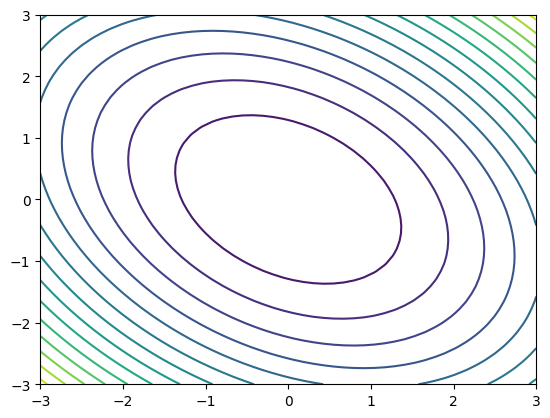

In [27]:
# here's some code to make a contour plot of the 2d quadratic function
# once you've minimized it with gradient descent, plot the sequence of approximation points on top of it
x = np.linspace(-3, 3)
y = np.linspace(-3, 3)
X, Y = np.meshgrid(x, y)
Z = quadratic_2d(np.stack([X, Y]))
plt.contour(X, Y, Z, levels = 15)

## Exercise 2: Using `scipy`

The `scipy` library has functions to do everything we've done so far and much, much more. There is a convenient routine called `minimize` in the `scipy.optimize` library.

Minimize the same objective functions defined above, this time using `scipy.optimize.minimize`. Note that this routine will not return a list of steps and function values, but only the final value

In [56]:
import scipy as sp
sp.optimize.minimize

<function scipy.optimize._minimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)>

## Exercise 3: Least squares and curve fitting

This is where optimization forms the bridge from scientific computing into data science. One of the most prevalent applications of optimization is data fitting, i.e. you've measured some data and want to select parameter values in a mathematical model for those data. To find the right parameter values, you write down an optimization problem where the objective function quantifies how well the mathematical model matches the data.

A *least squares* problem is a special type of optimization problem, where the objective function has the form:
$$
f(x) = {1\over 2}\sum_{j=1}^{m} f_j(x)^2
$$
The `scipy` routine `scipy.optimize.least_squares` solves least squares problem, and takes a function `fun` that outputs the residuals: `fun(x) = [f1(x), f2(x), ..., fm(x)]`.

Write a wrapper function that takes a residuals function and solves it by passing to a the `gradient_descent` function you wrote before

In [64]:
def my_least_squares(residuals, gradients, x0, **options):
    """
    wrapper function that solves a least squares problem by passing to a minimizer routine

    INPUT:
        residuals : the function that produces the vector of residuals
        gradients : a list of functions giving the gradients of the residuals. gradients[j] should compute the gradient of fun(x)[j] with respect to x
        x0 : initial point
        options : keyword arguments to pass on to the gradient descent solver

    OUTPUT:
        the results of gradient descent optimization of the least squares problem
    """
    fun = lambda x : None
    def grad(x):
        return
    return gradient_descent(fun, grad, x0, **options)


Least squares problems often occur when fitting a model to noisy data. When we minimize the square of the difference between a model's prediction and the data, we are implicitly assuming that the data have been corrupted by Gaussian noise.

A special type of least squares problem that we will deal heavily with in the future is *curve fitting*. In a curve fitting problem, you have measurements of an independent variable `x` and a dependent variable `y`, and wish to find parameter values that define a functional relationship $y = f(x; p)$. Note we have changed notation: now the optimization variable is $p$, because $x$ is now the independent variable we have measurements of.

Curve fitting is a least squares problem with the following objective function:
$$
f(p) = \sum_{j=1}^{m} (y_j - f(x_j; p))^2
$$

Write a wrapper function that takes a curve fitting problem and transforms it into a least squares problem, and solves it by calling the `my_least_squares` function

NOTE: For compatability with scipy's curve fit routine, the function `func` below should take `m+1` arguments, where `m` is the number of parameters that specify the function shape (i.e. the dimension of `p`). This is in contrast to `func` taking just two parameters, `x` and `p`, the latter of which is an `m`-dimensional array. The consequence of this is that when you write a call to `func`, it should take the form `func(x, *p)` (as opposed to just `func(x, p)`). The `*` before `p` tells python to "unpack" the array `p` and pass each element as a separate argument.

This makes it so that we can define a single `func` that implements the model we want to fit, and pass it to both `my_curve_fit` or `sp.optimize.curve_fit`

In [65]:
def my_curve_fit(func, dfuncdp, xdata, ydata, p0, **options):
    """
    wrapper function that solves a curve fitting problem by passing to a least squares routine

    INPUT:
        func : the function that defines the shape of the curve that should be fit.
            It should have the form y = f(x, *p) where p is the vector of parameters to be optimized
        dfuncdp : gradient of the function with respect to the parameters p
            It should have the form dfuncdp(x, *p) where p is the vector of parameters to be optimized
        x0 : initial point
        options : keyword arguments to pass on to the gradient descent solver

    OUTPUT:
        the results of gradient descent optimization of the curve fitting problem
    """
    def residuals(p):
        return
    gradients = [lambda p : None for _ in xdata]
    return my_least_squares(residuals, gradients, p0, **options)

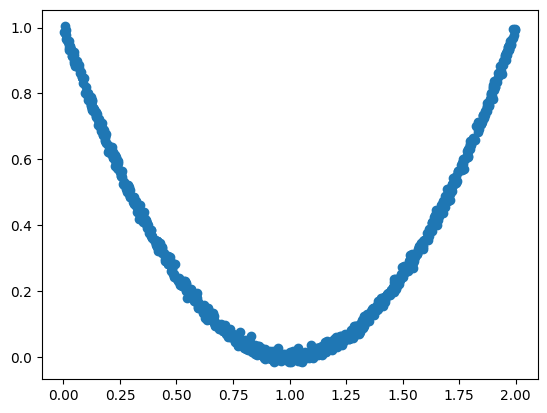

In [59]:
# Test out your curve fitting function
N = 1000
noise_level = 1e-2
# define the true functional relationship between x and y
truefunction = lambda x : (x-1)**2

# generate synthetic data
xdata = 2*np.random.rand(N)
# generate noise to add to the true function
noise = np.random.randn(N)*noise_level
ydata = truefunction(xdata) + noise

plt.scatter(xdata, ydata)

In [80]:
# the function below defines a generic quadratic function
def func(x, *p):
    return p[0] + p[1]*x + p[2]*x**2
def dfuncdp(x, *p):
    return np.array([np.ones_like(x), x, x**2])

p0 = np.array([0,0,0])
# pvals, fvals = my_curve_fit(func, dfuncdp, xdata, ydata, p0)

In [76]:
# check your results against using scipy's curve fit function
sp.optimize.curve_fit(func, xdata, ydata, p0=p0)

(array([ 1.00015222, -1.99948751,  0.99952139]),
 array([[ 8.65323687e-07, -1.73037136e-06,  7.24406414e-07],
        [-1.73037136e-06,  4.59239994e-06, -2.16263049e-06],
        [ 7.24406414e-07, -2.16263049e-06,  1.08647729e-06]]))